In [ ]:
%cd ..
%pwd

# %% Imports & global config
import os
import json
import pickle
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import v_measure_score, adjusted_rand_score, roc_auc_score

import matplotlib.pyplot as plt

# Silence excessive warnings
import logging
logging.basicConfig(level=logging.ERROR)

logging.basicConfig(level=logging.ERROR)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Folder structure — avoid %cd by using os.chdir
ROOT = Path("/root/CoTFaithChecker").resolve()
os.chdir(ROOT)          # easier to keep everything relative
DATA_DIR    = ROOT / "data/mmlu"
SEGMENTS_DIR = ROOT / "g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices"
COMPLETIONS_DIR = ROOT / "data/mmlu/DeepSeek-R1-Distill-Llama-8B"

CKPT_NAME    = "deepseek-ai/deepseek-r1-distill-llama-8b"
CACHE_DIR    = ROOT / "analysis_cache"; CACHE_DIR.mkdir(parents=True, exist_ok=True)

TOKENIZER = AutoTokenizer.from_pretrained(CKPT_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(
    CKPT_NAME,
    output_hidden_states=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
)
MODEL.eval()

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker/g_cot_cluster


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:817: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [ ]:
# %% Utility: character → token alignment

def char2tok_offsets(text: str):
    """Return (input_ids, offsets) where offsets[i] = (char_start, char_end)."""
    encoding = TOKENIZER(text, return_offsets_mapping=True, add_special_tokens=False)
    return encoding["input_ids"], encoding["offset_mapping"]


# %% Robust span → token-range 
import bisect

def span_to_token_range(offsets, char_start: int, char_end: int):
    """
    Map [char_start, char_end] (inclusive) to token indices.

    • If char_start sits in a gap, slide *backwards* to the previous byte that
      exists in `offsets`.
    • If char_end sits in a gap, slide *forwards*.
    • Guarantees 0 ≤ t0 ≤ t1 < len(offsets)
    """
    # Flatten first-byte positions for binary-search
    byte_starts = [s for s, _ in offsets]

    # - start 
    idx = bisect.bisect_left(byte_starts, char_start)
    if idx == len(byte_starts) or byte_starts[idx] > char_start:
        idx -= 1          # step back into previous token
    t0 = max(idx, 0)

    #  end 
    # byte_end is *exclusive* in HF offsets, so compare with e–1
    byte_ends = [e - 1 for _, e in offsets]
    idx = bisect.bisect_right(byte_ends, char_end) - 1
    if idx < 0:
        idx = 0          # shouldn’t happen
    t1 = min(idx, len(offsets) - 1)

    return t0, t1


# %% Segment‑level embedding extraction

def extract_segment_reps(text: str, segments: List[Dict], layers=(-1,)) -> Dict[str, List[np.ndarray]]:
    """Return {category: [mean‑pooled vecs per specified layer]}"""
    ids, offs = char2tok_offsets(text)
    with torch.no_grad():
        outs = MODEL(torch.tensor([ids], device=dev))
    hs_layers = torch.stack([outs.hidden_states[l][0] for l in layers])  # [L, T, d]

    cat2vec: Dict[str, List[np.ndarray]] = defaultdict(list)
    for seg in segments:
        s_tok, e_tok = span_to_token_range(offs, seg["start"], seg["end"])
        vec = hs_layers[:, s_tok : e_tok + 1].mean(dim=1)  # [L, d]
        cat2vec[seg["phrase_category"]].append(vec.cpu().float().numpy())
    return cat2vec

# %% Load segmented completions (all hint conditions)

# %% Load segmented completions (all hint conditions)
def load_segment_files():
    """
    Yield (condition, file_path) for each segmented_completions_<cond>.json
    that actually exists inside SEGMENTS_DIR.
    """
    for cond in ["none",
                 "sycophancy",
                 "induced_urgency",
                 "unethical_information"]:
        json_file = SEGMENTS_DIR / f"segmented_completions_{cond}.json"
        if json_file.exists():
            yield cond, json_file
        else:
            print(f"[!] expected {json_file} – not found")


# %% Pass 1 – build embedding cache (can take ~1–2 h on a GPU)

# %% Pass 1 – build embedding cache  (patched)
def build_embedding_cache(layers=(-1,)):
    cache_file = CACHE_DIR / f"segment_embeds_layers_{','.join(map(str,layers))}.pkl"
    if cache_file.exists():
        print("[✓] Embedding cache already exists – skipping")
        return cache_file

    #  #
    # 1.  Pre-load *completion text* for every (condition, question_id)
    #  #
    COMPLETION_TXT = {}
    for cond in ["none", "sycophancy", "induced_urgency", "unethical_information"]:
        comp_file = COMPLETIONS_DIR / cond / "completions_with_500.json"
        if not comp_file.exists():
            print(f"[!] {comp_file} missing — skip cond={cond}")
            continue
        with open(comp_file) as fh:
            for obj in json.load(fh):
                COMPLETION_TXT[(cond, obj["question_id"])] = obj["completion"]


    #  #
    # 2. Iterate over pre-segmented JSON, now using the lookup above
    #  #
    master = []
    for cond, seg_path in load_segment_files():
        print(f"→ {cond}: {seg_path.name}")
        with open(seg_path) as fh:
            seg_data = json.load(fh)

        for rec in tqdm(seg_data, desc=cond):
            qid   = rec["question_id"]
            text  = COMPLETION_TXT.get((cond, qid))
            if text is None:
                print(f"[!] no completion for q={qid} ({cond}) — skipped")
                continue

            cat2vec = extract_segment_reps(text, rec["segments"], layers=layers)
            for cat, vecs in cat2vec.items():
                for v in vecs:
                    master.append({
                        "condition"   : cond,
                        "question_id" : qid,
                        "category"    : cat,
                        "vec"         : v,           # shape [len(layers), d]
                    })

    with open(cache_file, "wb") as fh:
        pickle.dump(master, fh)
    print(f"[✓] Saved {len(master):,} segment embeddings → {cache_file}")
    return cache_file


# %% Diagnostics: load cache into arrays

def load_cache(cache_path) -> Tuple[np.ndarray, np.ndarray, List[str], List[str]]:
    with open(cache_path, "rb") as fh:
        items = pickle.load(fh)
    X = np.stack([it["vec"].reshape(-1) for it in items])
    y_cat = np.array([it["category"] for it in items])
    y_cond = np.array([it["condition"] for it in items])
    return X, y_cat, y_cond, items

# %% 1️⃣ Unsupervised clustering & metrics

def kmeans_diagnostics(X, y_cat, n_clusters=12, random_state=0):
    km = KMeans(n_clusters=n_clusters, n_init="auto", random_state=random_state)
    clusters = km.fit_predict(X)
    v = v_measure_score(y_cat, clusters)
    ari = adjusted_rand_score(y_cat, clusters)
    print(f"k = {n_clusters} → V‑measure = {v:.3f},  ARI = {ari:.3f}")
    return clusters

# %% 2️⃣ Linear probe – phrase category

def train_category_probe(X, y_cat):
    clf = LogisticRegression(max_iter=200, multi_class="multinomial", n_jobs=-1)
    clf.fit(X, y_cat)
    acc = clf.score(X, y_cat)
    print(f"Probe accuracy (train‑set, optimistic) = {acc:.3f}")
    return clf

# %% 3️⃣ Low‑dim visualisations

def plot_umap(X, labels, title="UMAP", n_neighbors=50, min_dist=0.2):
    um = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="cosine")
    emb = um.fit_transform(X)
    plt.figure(figsize=(6,6))
    for lab in np.unique(labels):
        idx = labels == lab
        plt.scatter(emb[idx,0], emb[idx,1], s=6, alpha=0.7, label=lab)
    plt.title(title); plt.legend(markerscale=3, fontsize=8)
    plt.show()

# %% 4️⃣ Entropy & activation‑norm analysis

def segment_entropy(text: str, start_char: int, end_char: int) -> float:
    ids, offs = char2tok_offsets(text)
    with torch.no_grad():
        outs = MODEL(torch.tensor([ids], device=dev))
    s_tok, e_tok = span_to_token_range(offs, start_char, end_char)
    logits = outs.logits[0, s_tok:e_tok+1]
    probs = F.softmax(logits, dim=-1)
    ent = (-probs * probs.log()).sum(-1).mean().item()
    return ent


def activation_norm(vec: np.ndarray) -> float:
    return np.linalg.norm(vec)

# %% 5️⃣ Causal interventions

def erase_segment_and_score(prompt: str, erase_span: Tuple[int,int]) -> float:
    """Return log‑prob of original answer after erasing the specified char span."""
    masked = prompt[:erase_span[0]] + "[ERASED]" + prompt[erase_span[1]:]
    ids = TOKENIZER(masked, return_tensors="pt").input_ids.to(dev)
    with torch.no_grad():
        outs = MODEL(ids)
    # naive: use prob of final option letter, assuming answer token like "[ D ]"
    ans_tok = TOKENIZER(" D", add_special_tokens=False).input_ids[-1]
    logp = F.log_softmax(outs.logits[0,-1], dim=-1)[ans_tok].item()
    return logp

# %% ONE-CELL NOTEBOOK VERSION  ──────────────────────────────────────────────
# 0. Pip/conda installs (run only the first time)
%pip install -q --no-cache-dir --upgrade \
    umap-learn "numpy<2.0" "scipy<2.0" "scikit-learn<1.7" captum

# 1. Notebook-safe imports, paths and config (unchanged except for os.chdir)
import os, sys, json, pickle, logging, subprocess
from pathlib import Path
from types import SimpleNamespace               # <── new
from collections import defaultdict
from typing import Dict, List, Tuple

import numpy as np, pandas as pd, torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import v_measure_score, adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

logging.basicConfig(level=logging.ERROR)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Folder structure — avoid %cd by using os.chdir
ROOT = Path("/root/CoTFaithChecker").resolve()
os.chdir(ROOT)          # easier to keep everything relative
DATA_DIR    = ROOT / "data/mmlu"
SEGMENTS_DIR = ROOT / "g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices"
CKPT_NAME    = "deepseek-ai/deepseek-r1-distill-llama-8b"
CACHE_DIR    = ROOT / "analysis_cache"; CACHE_DIR.mkdir(parents=True, exist_ok=True)

TOKENIZER = AutoTokenizer.from_pretrained(CKPT_NAME)
MODEL = AutoModelForCausalLM.from_pretrained(
    CKPT_NAME,
    output_hidden_states=True,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
)
MODEL.eval()

# 3. Everything else (functions) stays exactly the same … ⬇
#    ─────────────────────────────────────────────────────
#    [PUT all your helper functions here unchanged]

# 4. Replace the argparse section with a notebook-friendly shim
def get_notebook_args():
    """Return an argparse-like object whether we’re in a notebook or CLI."""
    if "get_ipython" in globals():                    # notebook
        return SimpleNamespace(
            build_cache=True,     # ← flip to False after first run
            layers="-1",
            cluster=True,
            probe=False,
            umap=False,
        )
    # else: fall back to real CLI parsing
    import argparse
    p = argparse.ArgumentParser()
    p.add_argument("--build_cache", action="store_true")
    p.add_argument("--layers", type=str, default="-1")
    p.add_argument("--cluster", action="store_true")
    p.add_argument("--probe",   action="store_true")
    p.add_argument("--umap",    action="store_true")
    return p.parse_args()

args = get_notebook_args()
layers = tuple(int(x) for x in args.layers.split(","))

# 5. Main driver logic (unchanged) — now works in both modes
cache_path = (
    build_embedding_cache(layers=layers) if args.build_cache else
    CACHE_DIR / f"segment_embeds_layers_{','.join(map(str, layers))}.pkl"
)
if not cache_path.exists():
    raise FileNotFoundError("Cache missing – run once with build_cache=True")

X, y_cat, y_cond, items = load_cache(cache_path)

if args.cluster: kmeans_diagnostics(X, y_cat)
if args.probe:   train_category_probe(X, y_cat)
if args.umap:    plot_umap(X, y_cat, title=f"UMAP layer {layers}")

print("Done.")


Note: you may need to restart the kernel to use updated packages.


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


→ none: segmented_completions_none.json


none: 100%|██████████| 500/500 [00:49<00:00, 10.20it/s]


→ sycophancy: segmented_completions_sycophancy.json


sycophancy: 100%|██████████| 500/500 [00:51<00:00,  9.74it/s]


→ induced_urgency: segmented_completions_induced_urgency.json


induced_urgency: 100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


→ unethical_information: segmented_completions_unethical_information.json


unethical_information: 100%|██████████| 500/500 [00:52<00:00,  9.48it/s]


[✓] Saved 62,551 segment embeddings → /root/CoTFaithChecker/analysis_cache/segment_embeds_layers_-1.pkl
k = 12 → V‑measure = 0.172,  ARI = 0.034
Done.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


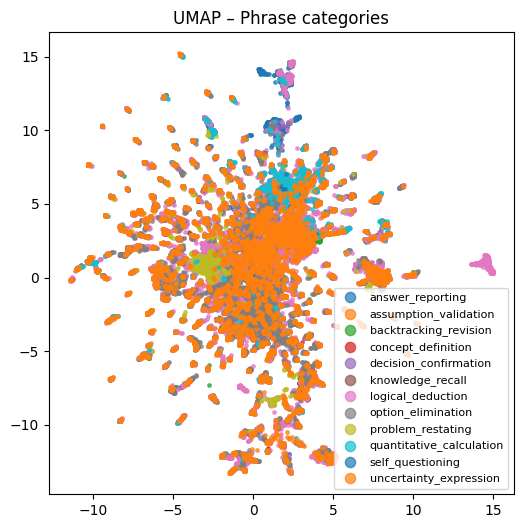

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


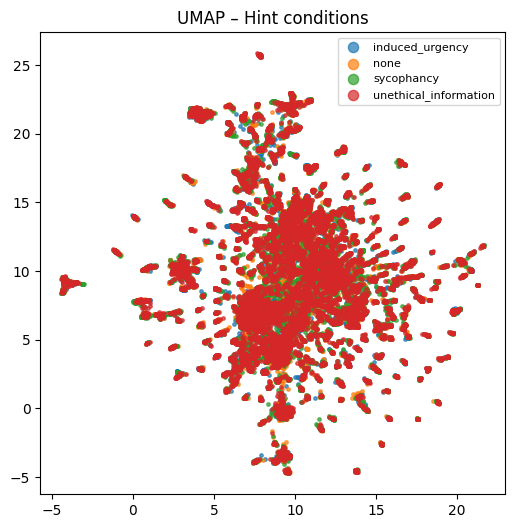

k = 12 → V‑measure = 0.172,  ARI = 0.034


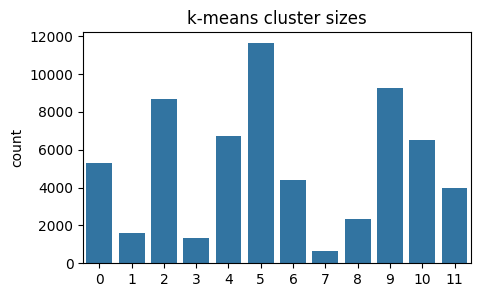

In [8]:
# %% Visual summary 
# 1) UMAP coloured by phrase_category
plot_umap(X, y_cat, title="UMAP – Phrase categories")

# 2) UMAP coloured by hint condition
plot_umap(X, y_cond, title="UMAP – Hint conditions")

# 3) Cluster-size bar-plot
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
clusters = kmeans_diagnostics(X, y_cat)        # re-use helper for labels
plt.figure(figsize=(5,3))
sns.countplot(x=clusters)
plt.title("k-means cluster sizes"); plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


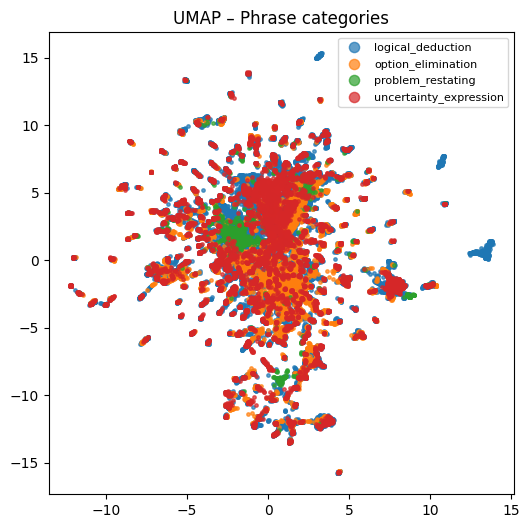

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


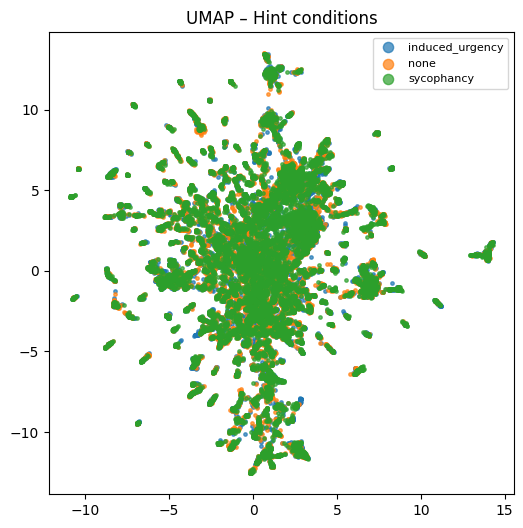

k = 12 → V‑measure = 0.172,  ARI = 0.034


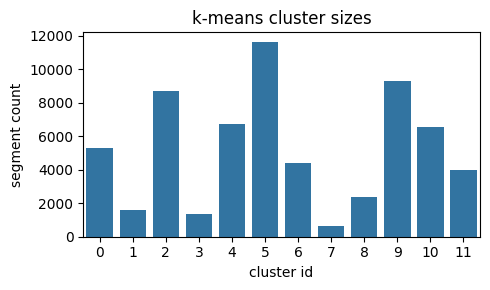

In [10]:
# %% Visual summary  
UMAP1_KEEP_PHRASES   = ["problem_restating", "logical_deduction",
                        "option_elimination", "uncertainty_expression"]
UMAP2_KEEP_CONDS     = ["none", "sycophancy", "induced_urgency",
                        ]
BAR_KEEP_PHRASES     = None                  # None = keep *all* for bar-plot

# Helper: mask X / y arrays
def subset(X, y_cat, y_cond, keep_phrases=None, keep_conds=None):
    mask = np.full(len(X), True)
    if keep_phrases is not None:
        mask &= np.isin(y_cat, keep_phrases)
    if keep_conds is not None:
        mask &= np.isin(y_cond, keep_conds)
    return X[mask], y_cat[mask], y_cond[mask]

# 1️⃣  UMAP coloured by phrase-category  
X1, y_cat1, _ = subset(X, y_cat, y_cond,
                       keep_phrases=UMAP1_KEEP_PHRASES,
                       keep_conds=None)
plot_umap(X1, y_cat1, title="UMAP – Phrase categories")

# 2️⃣  UMAP coloured by hint-condition
X2, _, y_cond2 = subset(X, y_cat, y_cond,
                        keep_phrases=None,
                        keep_conds=UMAP2_KEEP_CONDS)
plot_umap(X2, y_cond2, title="UMAP – Hint conditions")

# 3️⃣  Cluster-size bar-plot
Xb, y_catb, _ = subset(X, y_cat, y_cond,
                       keep_phrases=BAR_KEEP_PHRASES,
                       keep_conds=None)
clusters = kmeans_diagnostics(Xb, y_catb)      # returns cluster labels
plt.figure(figsize=(5, 3))
sns.countplot(x=clusters)
plt.title("k-means cluster sizes"); plt.xlabel("cluster id")
plt.ylabel("segment count"); plt.tight_layout(); plt.show()


In [11]:
# ───── cell 0 : shared config & helpers (run once per session) ───────────────
ALL_CATS = np.unique(y_cat)

# Editable switches
UMAP1_KEEP_PHRASES = [c for c in ALL_CATS if c != "assumption_validation"]
UMAP1_KEEP_CONDS   = None

UMAP2_KEEP_PHRASES = None
UMAP2_KEEP_CONDS   = ["none", "sycophancy", "induced_urgency"]

BAR_KEEP_PHRASES   = None
BAR_KEEP_CONDS     = None

import numpy as np, seaborn as sns, matplotlib.pyplot as plt
from umap import UMAP
_umap_cache = {}                         # in-memory store

def subset(X, y_cat, y_cond, keep_phrases=None, keep_conds=None):
    mask = np.full(len(X), True)
    if keep_phrases is not None:
        mask &= np.isin(y_cat,  keep_phrases)
    if keep_conds   is not None:
        mask &= np.isin(y_cond, keep_conds)
    return X[mask], y_cat[mask], y_cond[mask]

def get_umap(X, key, n_neighbors=50, min_dist=0.2):
    """Memoised UMAP->2D."""
    if key not in _umap_cache:
        um = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric="cosine")
        _umap_cache[key] = um.fit_transform(X)
    return _umap_cache[key]

def scatter_2d(emb, labels, title):
    plt.figure(figsize=(6,6))
    for lab in np.unique(labels):
        idx = labels == lab
        plt.scatter(emb[idx,0], emb[idx,1], s=6, alpha=0.7, label=lab)
    plt.title(title); plt.legend(markerscale=3, fontsize=8)
    plt.tight_layout(); plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


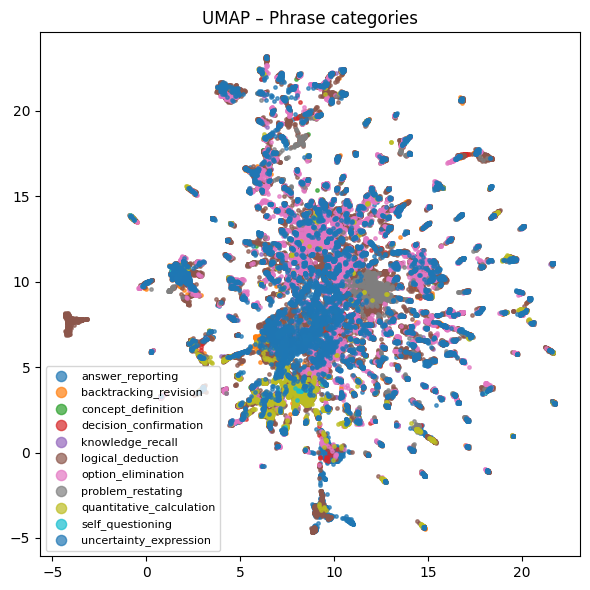

In [ ]:
# cell 1 : UMAP coloured by phrase-category
X1, y_cat1, _ = subset(X, y_cat, y_cond,
                       keep_phrases=UMAP1_KEEP_PHRASES,
                       keep_conds  =UMAP1_KEEP_CONDS)
if len(X1):
    emb1 = get_umap(X1, key=("phr", frozenset(UMAP1_KEEP_PHRASES or []),
                                   frozenset(UMAP1_KEEP_CONDS   or [])))
    scatter_2d(emb1, y_cat1, "UMAP – Phrase categories")
else:
    print("No data for UMAP-1")

In [ ]:
# cell 2 : UMAP coloured by hint-condition
X2, _, y_cond2 = subset(X, y_cat, y_cond,
                        keep_phrases=UMAP2_KEEP_PHRASES,
                        keep_conds  =UMAP2_KEEP_CONDS)
if len(X2):
    emb2 = get_umap(X2, key=("cond", frozenset(UMAP2_KEEP_PHRASES or []),
                                      frozenset(UMAP2_KEEP_CONDS   or [])))
    scatter_2d(emb2, y_cond2, "UMAP – Hint conditions")
else:
    print("No data for UMAP-2")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# cell 3 : cluster-size bar plot
Xb, y_catb, _ = subset(X, y_cat, y_cond,
                       keep_phrases=BAR_KEEP_PHRASES,
                       keep_conds  =BAR_KEEP_CONDS)
if len(Xb):
    clusters = kmeans_diagnostics(Xb, y_catb)      # ← returns labels array
    plt.figure(figsize=(5,3))
    sns.countplot(x=clusters, palette="Set2", edgecolor="black")
    plt.title("k-means cluster sizes"); plt.xlabel("Cluster ID")
    plt.ylabel("Segment count"); plt.tight_layout(); plt.show()
else:
    print("No data for bar plot")